In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import linregress

### Langevin Equation
$$ \gamma_0 \dot{x_1} =  a_{00} x_1 + a_{01} x_2  + \sqrt{2k_B T \gamma_0}ξ_0 $$
$$ \gamma_1 \dot{x_2} =  a_{10} x_1 + a_{11} x_2  + \sqrt{2k_B T \gamma_1}ξ_1 $$

Which we can rewrite as:

$$ \dot{x_1} = \frac{a_{00}}{\gamma_0} x_1 + \frac{a_{01}}{\gamma_0} x_2 + \sqrt{\frac{2k_B T_1 \gamma_0}{\gamma_0^2}}ξ_0 $$
$$ \dot{x_2} =  \frac{a_{10}}{\gamma_1} x_1 + \frac{a_{11}}{\gamma_1} x_2 + \sqrt{\frac{2k_B T_2 \gamma_1}{\gamma_1^2}}ξ_1 $$

where: $a_{00} = -1$, $a_{01} = -0.5$, $a_{10} = -0.5$, $a_{11} = -1$, $k_B T = 4.1$, $\gamma_0 = 1$, $\gamma_1 = 1$

### Euler method

Euler Scheme

$$ X_{t+\Delta t} = X_t + f(X_t, t)\Delta t + g(X_t,t)\Delta B_t $$

where $$ \Delta B_t = \mathcal{N}(0, \sqrt\Delta t) $$

In [2]:
#paramaters
#change all units to: force = pN, length = nm, time = ms
pars = {}
pars['a00'] = -1
pars['a01'] = -0
pars['a10'] = -0.5
pars['a11'] = -1
pars['gamma0'] = 1
pars['gamma1'] = 1

pars['kb'] = 1.38*10**-2

pars['T0'] = 300
pars['T1'] = 400
pars['noise0'] = 2*pars['gamma0']*pars['kb']*pars['T0']
pars['noise1'] = 2*pars['gamma1']*pars['kb']*pars['T1']

pars['n_realizations'] = 100
pars['delta_t'] = 0.01

In [3]:
def euler_one_traj(n_time, pars):   
    #initial condition
    x1 = 0
    x2 = 0
    x1_traj = []
    x2_traj = []
    
    #performing 1 traj with n_time number of data points
    for i in range(n_time):
        #generate delta_B
        s1 = np.random.normal(0, np.sqrt(pars['delta_t']) )
        s2 = np.random.normal(0, np.sqrt(pars['delta_t']) )
        #solve for x1, x2
        x1_new = x1 + (pars['a00']/pars['gamma0'])*x1*pars['delta_t'] + \
        (pars['a01']/pars['gamma0'])*x2*pars['delta_t'] + \
        np.sqrt((pars['noise0'])/((pars['gamma0'])**2))*s1
                 
        x2_new = x2 + (pars['a11']/pars['gamma1'])*x2*pars['delta_t'] + \
        (pars['a10']/pars['gamma1'])*x1*pars['delta_t'] + \
        np.sqrt((pars['noise1'])/((pars['gamma1'])**2))*s2
                
        x1 = x1_new
        x2 = x2_new
        
        x1_traj.append(x1)
        x2_traj.append(x2)
    return x1_traj, x2_traj

### Functions for stochastic heat

### Stochastic Heat:

$$ 0 = - \gamma_0 \dot{x_1} + \sqrt{2k_B T \gamma_0}ξ_0 + a_{00} x_1 + a_{01} x_2  $$
$$ 0 = - \gamma_1 \dot{x_2} + \sqrt{2k_B T \gamma_1}ξ_1 + a_{10} x_1 + a_{11} x_2   $$

For $x_1$:

$$ \delta Q_1 = (-\gamma_0 \dot{x} + \sqrt{2k_B T \gamma_0}ξ_0) \circ dx_1  = -(a_{00} x_1 + a_{01} x_2) \circ dx_1$$

$$ \delta Q_1 = -(a_{00} x_1 + a_{01} x_2) \circ dx_1 $$

For $x_2$:

$$ \delta Q_2 = (-\gamma_1 \dot{x} + \sqrt{2k_B T \gamma_1}ξ_1) \circ dx_2  = -(a_{10} x_1 + a_{11} x_2) \circ dx_2$$

$$ \delta Q_2 = -(a_{10} x_1 + a_{11} x_2) \circ dx_2 $$

Final equation for stochastic heat:

$$ \delta Q_1 = -(a_{00} x_1 + a_{01} x_2) \circ dx_1  $$

$$ \delta Q_2 = -(a_{11} x_2 + a_{10} x_1) \circ dx_2  $$

In [4]:
def calc_stochastic_heat_q1(x1, x2, pars):
    """Calculates stochastic heat per time delta following equation (3)
    Input:
    x1 (list) = x1_trajectory_list
    x2 (list) = x2_trajectory_list
    pars (dictionary) = parameters
    
    Here's an example:
    x1 =       [1,2,3,4,5]
    x1_shift = [5,1,2,3,4]
    Then we can easily calculate operations, e.g. dx1 = x1 - x1_ shift
    Vectorization (technique of implementing array operations without using for loop) is easier.
    
    After which, we discard the first element
    
    Returns:
    stochastic heat as shown in equation (3)"""
    x1_shift = np.roll(x1, shift = 1)   
    x2_shift = np.roll(x2, shift = 1)
    
    first_term = -pars['a00']*((x1 + x1_shift)/2)
    second_term = -pars['a01']*((x2 + x2_shift)/2)
    dx1 = x1 - x1_shift
    return (first_term[1:] + second_term[1:])*dx1[1:]

def calc_stochastic_heat_q2(x1, x2, pars):
    x1_shift = np.roll(x1, shift = 1)   
    x2_shift = np.roll(x2, shift = 1)    
    
    first_term = -pars['a11']*((x2 + x2_shift)/2)
    second_term = -pars['a10']*((x1 + x1_shift)/2)
    dx2 = x2 - x2_shift
    return (second_term[1:] + first_term[1:])*dx2[1:]

In [5]:
#function to calculate average q (cumulative_heat) after performing n_realizations
def average_q(max1_time, pars):
    min_time = 0
    n_time = int((max1_time - min_time)/pars['delta_t'] + 1) #n_time = num of evenlx2 spaced samples (ex1. 1001 points)
    time = np.linspace(min_time, max1_time, n_time) #time(ex1. 0 (min time), 0.01, 0.02, ..., 10 (max1 time)) with n_time no. of data points
    
    average_q1_trajectorx2 = 0
    average_q2_trajectorx2 = 0
    
    relax_time = int(abs(pars['gamma0']/pars['a00']))
    
    for i in range(pars['n_realizations']):
        x1_traj, x2_traj = euler_one_traj(n_time, pars)
        final_x1_traj = x1_traj[relax_time::]
        final_x2_traj = x2_traj[relax_time::]
        
        
        q1_trajectorx2 = calc_stochastic_heat_q1(final_x1_traj, final_x2_traj, pars)
        q1_cumulative = np.cumsum(q1_trajectorx2)
        
        q2_trajectorx2 = calc_stochastic_heat_q2(final_x1_traj, final_x2_traj, pars)
        q2_cumulative = np.cumsum(q2_trajectorx2)
        
        average_q1_trajectorx2 += q1_cumulative/pars['n_realizations']
        average_q2_trajectorx2 += q2_cumulative/pars['n_realizations']
        
    return average_q1_trajectorx2, average_q2_trajectorx2, time[:-1]

In [6]:
def analytical_q0(pars):
    numerator = pars['a01']*((pars['a10']*pars['T0'])-(pars['a01']*pars['T1']))
    denominator = (pars['a00']*pars['gamma1']) + (pars['a11']*pars['gamma0'])
    
    return pars['kb']*(numerator/denominator)

def analytical_q1(pars):
    numerator = pars['a10']*((pars['a01']*pars['T1'])-(pars['a10']*pars['T0']))
    denominator = (pars['a00']*pars['gamma1']) + (pars['a11']*pars['gamma0'])
    
    return pars['kb']*(numerator/denominator)

In [7]:
def calculate_a01(pars, a01_list_final):    
    q0_list = []
    q1_list = []
    for i in tqdm(a01_list_final):
        pars['a01'] = i
        
        q0_analytical = analytical_q0(pars)
        q0_list.append(q0_analytical)
        
        q1_analytical = analytical_q1(pars)
        q1_list.append(q1_analytical)
        
    return q0_list, q1_list

In [8]:
a01_list = np.arange(0, 0.5 + 0.01, 0.01)
a01_list_final = np.array(-1)*a01_list
a01_list_final

array([-0.  , -0.01, -0.02, -0.03, -0.04, -0.05, -0.06, -0.07, -0.08,
       -0.09, -0.1 , -0.11, -0.12, -0.13, -0.14, -0.15, -0.16, -0.17,
       -0.18, -0.19, -0.2 , -0.21, -0.22, -0.23, -0.24, -0.25, -0.26,
       -0.27, -0.28, -0.29, -0.3 , -0.31, -0.32, -0.33, -0.34, -0.35,
       -0.36, -0.37, -0.38, -0.39, -0.4 , -0.41, -0.42, -0.43, -0.44,
       -0.45, -0.46, -0.47, -0.48, -0.49, -0.5 ])

In [9]:
T1_list = [200, 250, 300, 350, 400]

q0_temp_list = []
q1_temp_list = []
for temp in T1_list:
    pars['T1'] = temp
    pars['noise1'] = 2*pars['gamma1']*pars['kb']*pars['T1']
    
    q0, q1 = calculate_a01(pars, a01_list_final)
    q0_temp_list.append(q0)
    q1_temp_list.append(q1)

100%|██████████| 51/51 [00:00<?, ?it/s]


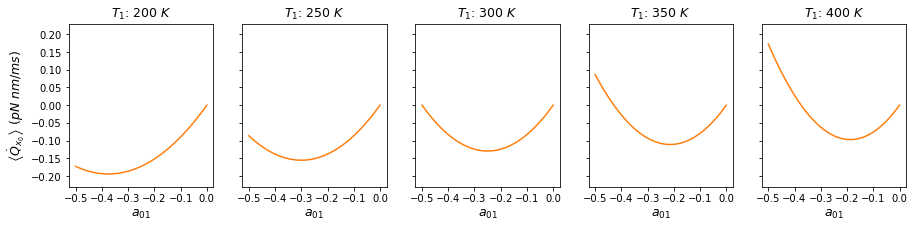

In [10]:
fig, ax = plt.subplots(1,5, figsize=(15,3), sharey=True)
a01_list = np.arange(0, 0.5 + 0.01, 0.01)
T1_list = [200, 250, 300, 350, 400]
for i in range(len(q0_temp_list)):
#     ax[i].scatter((-1)*a01_list, np.array(qx1_slope_temp_list[i])*(-1), facecolors='none', edgecolors='tab:blue')
    ax[i].plot((-1)*a01_list, np.array(q0_temp_list[i]), color='tab:orange')
    ax[i].set_xticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0])
    ax[i].set_yticks([-0.20, -0.15, -0.10, -0.05, 0, 0.05, 0.10, 0.15, 0.20])
    ax[i].set_ylim(-0.23, 0.23)
    ax[i].set_xlabel('$a_{01}$', fontsize=12.5)
    ax[i].set_title('$T_1$: {} $K$'.format(T1_list[i]), fontsize=12.5)
ax[0].set_ylabel('$\\left<\dot{Q}_{x_0} \\right>$ ($pN$ $nm/ms$)', fontsize=12.5)
# plt.suptitle('Energy dissipated at varying $T_1$ and $a_{01}$, with $a_{10}$ = 0.5 and $T_0$ = 300 $K$', fontsize=12.5, y = 1.1)

# plt.savefig('q_varying_temp_800.png', dpi=300, bbox_inches='tight')
plt.show()

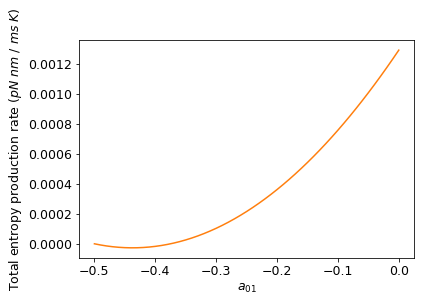

In [11]:
final_x0_analytical = np.array(q0_temp_list[2])
final_x1_analytical = np.array(q1_temp_list[2])

epr_analytical = (final_x0_analytical/np.array(pars['T0'])) + (final_x1_analytical/np.array(pars['T1'])) 
plt.plot((-1)*a01_list, epr_analytical, color='tab:orange', label='analytical solution')

plt.xlabel('$a_{01}$', fontsize=12.5)
plt.ylabel('Total entropy production rate ($pN$ $nm$ / $ms$ $K$)', fontsize=12.5)
plt.xticks(fontsize=12.5)
plt.yticks(fontsize=12.5)
plt.show()

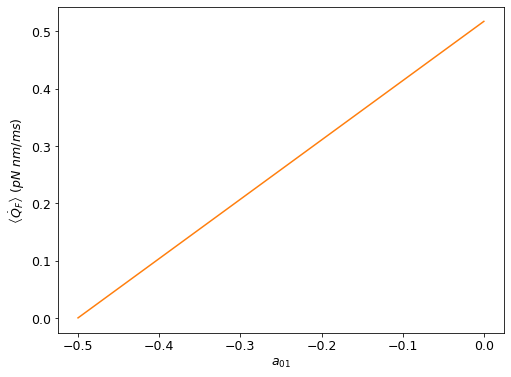

In [12]:
fig = plt.figure(figsize=(8,6))
plt.plot((-1)*a01_list, np.array(q1_temp_list[2]), color='tab:orange')

plt.xlabel('$a_{01}$', fontsize=12.5)
plt.ylabel('$\\left<\dot{Q}_F \\right>$ ($pN$ $nm/ms$)', fontsize=12.5)
plt.xticks(fontsize=12.5)
plt.yticks(fontsize=12.5)
# plt.ylim(-0.15,0.01)
# plt.savefig('reciprocity_q_x_800.png', dpi=300)

plt.show()

In [13]:
# def calculate_a01(pars, a01_list):    
#     qx1_slope_list = []
#     qx2_slope_list = []
    
#     qx1_list = []
#     qx2_list = []
#     for i in tqdm(a01_list):
#         pars['a01'] = -i
#         qx1_neq, qx2_neq, time = average_q(800, pars)
        
#         qx1_list.append(qx1_neq)
#         qx2_list.append(qx2_neq)

#         x_axis = np.linspace(0,len(qx1_neq)*pars['delta_t'], len(qx1_neq))
#         result_qx1_neq = linregress(x_axis, qx1_neq)
#         qx1_slope_list.append(result_qx1_neq.slope)
        
#         result_qx2_neq = linregress(x_axis, qx2_neq)
#         qx2_slope_list.append(result_qx2_neq.slope)
        
        
#     return qx1_slope_list, qx2_slope_list, qx1_list, qx2_list

In [14]:
# a01_list = np.arange(0, 0.5 + 0.01, 0.01)
# T1_list = [200, 250, 300, 350, 400]

# qx1_slope_temp_list = []
# qx2_slope_temp_list = []
# qx1_temp_list = []
# qx2_temp_list = []
# for temp in T1_list:
#     pars['T1'] = temp
#     pars['noise1'] = 2*pars['gamma1']*pars['kb']*pars['T1']
    
#     qx1_slope, qx2_slope, qx1, qx2 = calculate_a01(pars, a01_list)
#     qx1_slope_temp_list.append(qx1_slope)
#     qx2_slope_temp_list.append(qx2_slope)
#     qx1_temp_list.append(qx1)
#     qx2_temp_list.append(qx2)


In [15]:
import pickle
with open('qx1_slope_temp_list_v1.pkl', 'rb') as f:
    qx1_slope_temp_list = pickle.load(f)
    
with open('qx2_slope_temp_list_v1.pkl', 'rb') as f:
    qx2_slope_temp_list = pickle.load(f)
    
with open('qx1_temp_list_v1.pkl', 'rb') as f:
    qx1_temp_list = pickle.load(f)
    
with open('qx2_temp_list_v1.pkl', 'rb') as f:
    qx2_temp_list = pickle.load(f)

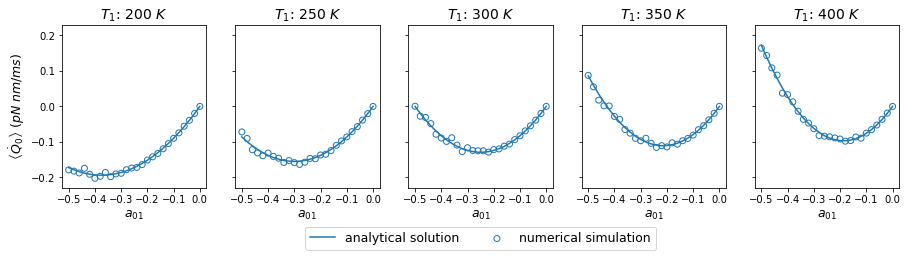

In [16]:
fig, ax = plt.subplots(1,5, figsize=(15,3), sharey=True)

a01_list = np.arange(0, 0.5 + 0.01, 0.01)
T1_list = [200, 250, 300, 350, 400]
for i in range(len(qx1_slope_temp_list)):
    ax[i].scatter((-1)*a01_list[::2], np.array(qx1_slope_temp_list[i][::2])*(-1), facecolors='none', edgecolors='tab:blue', label='numerical simulation')
    ax[i].plot((-1)*a01_list[::2], np.array(q0_temp_list[i][::2]), color='tab:blue', label='analytical solution')
    ax[i].set_xticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0])
    ax[i].set_ylim(-0.23, 0.23)
    ax[i].set_xlabel('$a_{01}$', fontsize=12.5)
    ax[i].set_title('$T_1$: {} $K$'.format(T1_list[i]), fontsize=14)
ax[0].set_ylabel('$\\left<\dot{Q}_{0}\\right>$ ($pN$ $nm/ms$)', fontsize=12.5)
ax[0].legend(loc='upper center', bbox_to_anchor=(2.9, -0.2), ncol=2, fontsize=12.5)
# plt.suptitle('Energy dissipated at varying $T_1$ and $a_{01}$, with $a_{10}$ = 0.5 and $T_0$ = 300 $K$', fontsize=12.5, y = 1.1)
# fig.tight_layout()
plt.savefig('q_qnum_varying_temp_fin.png', dpi=300, bbox_inches='tight')
plt.show()

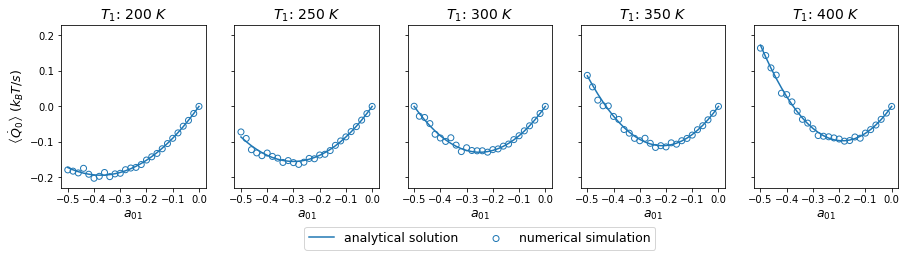

In [32]:
fig, ax = plt.subplots(1,5, figsize=(15,3), sharey=True)

a01_list = np.arange(0, 0.5 + 0.01, 0.01)
T1_list = [200, 250, 300, 350, 400]
for i in range(len(qx1_slope_temp_list)):
    ax[i].scatter((-1)*a01_list[::2], np.array(qx1_slope_temp_list[i][::2])*(-1), facecolors='none', edgecolors='tab:blue', label='numerical simulation')
    ax[i].plot((-1)*a01_list[::2], np.array(q0_temp_list[i][::2]), color='tab:blue', label='analytical solution')
    ax[i].set_xticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0])
    ax[i].set_ylim(-0.23, 0.23)
    ax[i].set_xlabel('$a_{01}$', fontsize=12.5)
    ax[i].set_title('$T_1$: {} $K$'.format(T1_list[i]), fontsize=14)
ax[0].set_ylabel('$\\left<\dot{Q}_{0}\\right>$ ($k_B T/s$)', fontsize=12.5)
ax[0].legend(loc='upper center', bbox_to_anchor=(2.9, -0.2), ncol=2, fontsize=12.5)
# plt.suptitle('Energy dissipated at varying $T_1$ and $a_{01}$, with $a_{10}$ = 0.5 and $T_0$ = 300 $K$', fontsize=12.5, y = 1.1)
# fig.tight_layout()
plt.savefig('q_qnum_varying_temp_fin_v1.png', dpi=300, bbox_inches='tight')
plt.show()

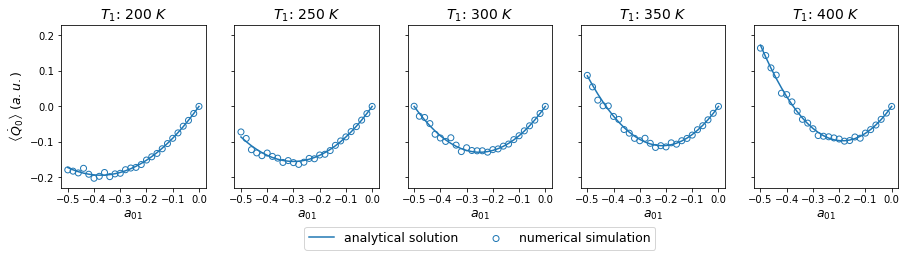

In [18]:
fig, ax = plt.subplots(1,5, figsize=(15,3), sharey=True)

a01_list = np.arange(0, 0.5 + 0.01, 0.01)
T1_list = [200, 250, 300, 350, 400]
for i in range(len(qx1_slope_temp_list)):
    ax[i].scatter((-1)*a01_list[::2], np.array(qx1_slope_temp_list[i][::2])*(-1), facecolors='none', edgecolors='tab:blue', label='numerical simulation')
    ax[i].plot((-1)*a01_list[::2], np.array(q0_temp_list[i][::2]), color='tab:blue', label='analytical solution')
    ax[i].set_xticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0])
    ax[i].set_ylim(-0.23, 0.23)
    ax[i].set_xlabel('$a_{01}$', fontsize=12.5)
    ax[i].set_title('$T_1$: {} $K$'.format(T1_list[i]), fontsize=14)
ax[0].set_ylabel('$\\left<\dot{Q}_{0}\\right>$ ($a.u.$)', fontsize=12.5)
ax[0].legend(loc='upper center', bbox_to_anchor=(2.9, -0.2), ncol=2, fontsize=12.5)
# plt.suptitle('Energy dissipated at varying $T_1$ and $a_{01}$, with $a_{10}$ = 0.5 and $T_0$ = 300 $K$', fontsize=12.5, y = 1.1)
# fig.tight_layout()
plt.savefig('q_qnum_varying_temp_fin_v2.png', dpi=300, bbox_inches='tight')
plt.show()

In [19]:
np.arange(0, 0.5 + 0.01, 0.01)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 ])

In [20]:
len(qx1_slope_temp_list[2])

51

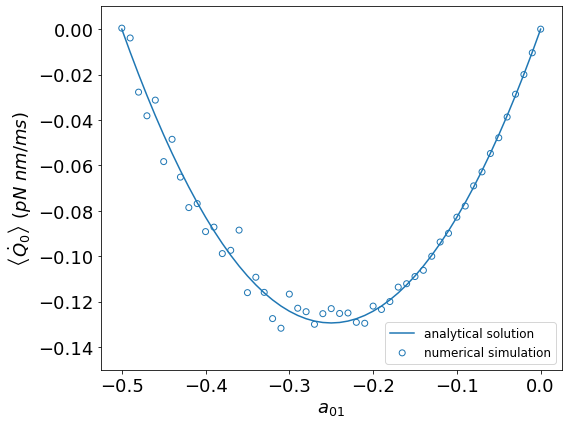

In [21]:
fig = plt.figure(figsize=(8,6))

plt.scatter((-1)*a01_list, (-1)*np.array(qx1_slope_temp_list[2]), facecolors='none', edgecolors='tab:blue', label='numerical simulation')
plt.plot((-1)*a01_list, np.array(q0_temp_list[2]), color='tab:blue', label='analytical solution')

plt.xlabel('$a_{01}$', fontsize=18)
plt.ylabel('$\\left<\dot{Q}_{0}\\right>$ ($pN$ $nm/ms$)', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(-0.15,0.01)
plt.legend(loc='lower right', fontsize=12)
plt.tight_layout()
plt.savefig('reciprocity_q_qnum_x_fin.png', dpi=300)

plt.show()

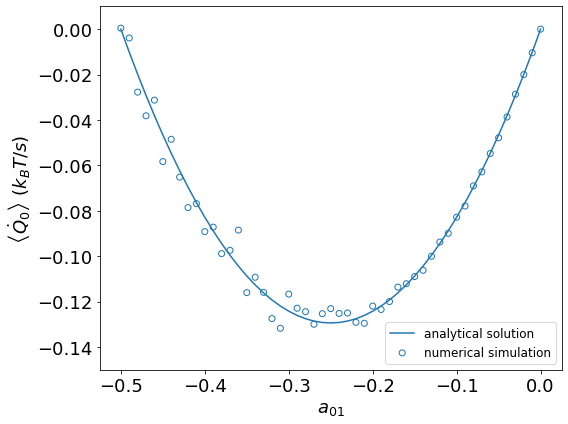

In [30]:
fig = plt.figure(figsize=(8,6))

plt.scatter((-1)*a01_list, (-1)*np.array(qx1_slope_temp_list[2]), facecolors='none', edgecolors='tab:blue', label='numerical simulation')
plt.plot((-1)*a01_list, np.array(q0_temp_list[2]), color='tab:blue', label='analytical solution')

plt.xlabel('$a_{01}$', fontsize=18)
plt.ylabel('$\\left<\dot{Q}_{0}\\right>$ ($k_B T/s$)', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(-0.15,0.01)
plt.legend(loc='lower right', fontsize=12)
plt.tight_layout()
plt.savefig('reciprocity_q_qnum_x_fin_v1.png', dpi=300)

plt.show()

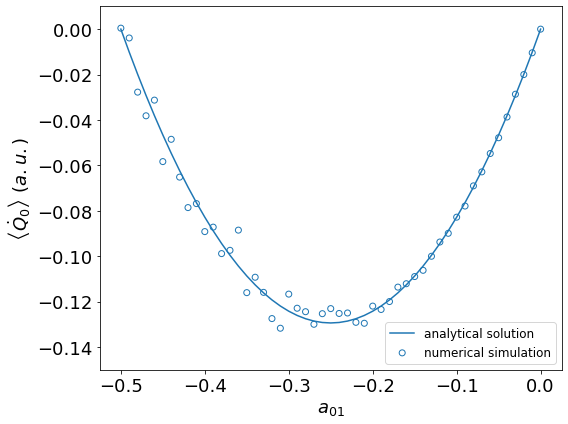

In [31]:
fig = plt.figure(figsize=(8,6))

plt.scatter((-1)*a01_list, (-1)*np.array(qx1_slope_temp_list[2]), facecolors='none', edgecolors='tab:blue', label='numerical simulation')
plt.plot((-1)*a01_list, np.array(q0_temp_list[2]), color='tab:blue', label='analytical solution')

plt.xlabel('$a_{01}$', fontsize=18)
plt.ylabel('$\\left<\dot{Q}_{0}\\right>$ ($a.u.$)', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(-0.15,0.01)
plt.legend(loc='lower right', fontsize=12)
plt.tight_layout()
plt.savefig('reciprocity_q_qnum_x_fin_v2.png', dpi=300)

plt.show()

Q1

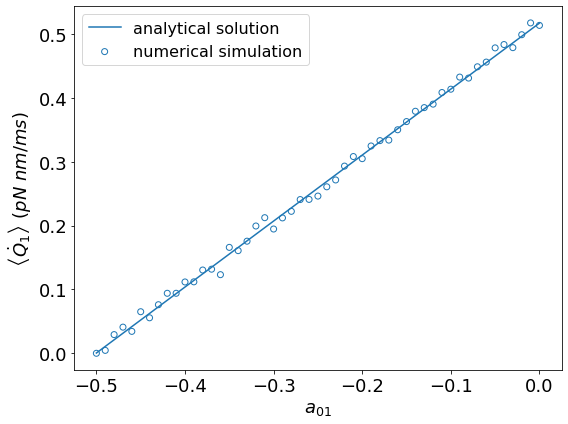

In [24]:
fig = plt.figure(figsize=(8,6))

plt.scatter((-1)*a01_list, (-1)*np.array(qx2_slope_temp_list[2]), facecolors='none', edgecolors='tab:blue', label='numerical simulation')
plt.plot((-1)*a01_list, np.array(q1_temp_list[2]), color='tab:blue', label='analytical solution')

plt.xlabel('$a_{01}$', fontsize=18)
plt.ylabel('$\\left<\dot{Q}_{1}\\right>$ ($pN$ $nm/ms$)', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=16)
# plt.ylim(-0.15,0.01)
plt.tight_layout()
plt.savefig('reciprocity_q_qnum_f_fin.png', dpi=300)

plt.show()

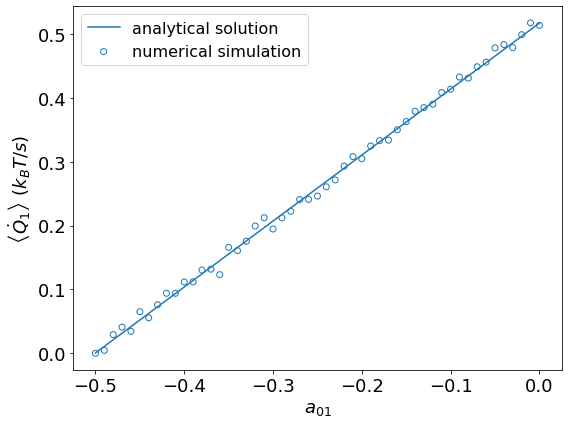

In [25]:
fig = plt.figure(figsize=(8,6))

plt.scatter((-1)*a01_list, (-1)*np.array(qx2_slope_temp_list[2]), facecolors='none', edgecolors='tab:blue', label='numerical simulation')
plt.plot((-1)*a01_list, np.array(q1_temp_list[2]), color='tab:blue', label='analytical solution')

plt.xlabel('$a_{01}$', fontsize=18)
plt.ylabel('$\\left<\dot{Q}_{1}\\right>$ ($k_B T/s$)', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=16)
# plt.ylim(-0.15,0.01)
plt.tight_layout()
plt.savefig('reciprocity_q_qnum_f_fin_v1.png', dpi=300)

plt.show()

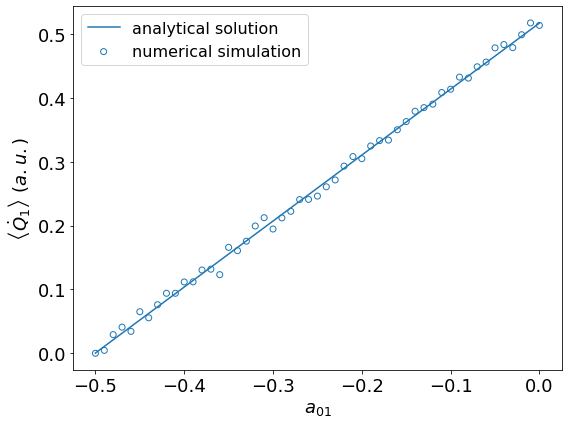

In [26]:
fig = plt.figure(figsize=(8,6))

plt.scatter((-1)*a01_list, (-1)*np.array(qx2_slope_temp_list[2]), facecolors='none', edgecolors='tab:blue', label='numerical simulation')
plt.plot((-1)*a01_list, np.array(q1_temp_list[2]), color='tab:blue', label='analytical solution')

plt.xlabel('$a_{01}$', fontsize=18)
plt.ylabel('$\\left<\dot{Q}_{1}\\right>$ ($a.u.$)', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=16)
# plt.ylim(-0.15,0.01)
plt.tight_layout()
plt.savefig('reciprocity_q_qnum_f_fin_v2.png', dpi=300)

plt.show()

Total EPR

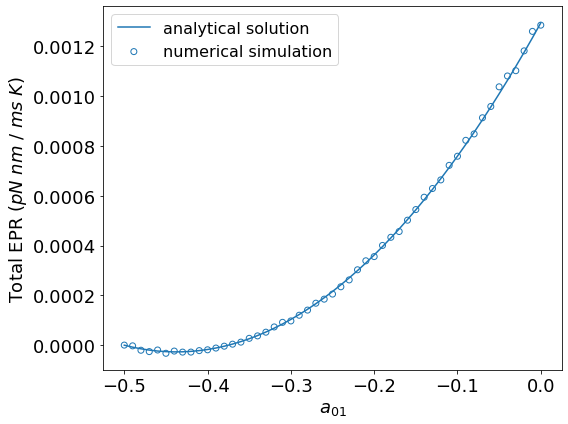

In [27]:
final_x0 = (-1)*np.array(qx1_slope_temp_list[2])
final_x1 = (-1)*np.array(qx2_slope_temp_list[2])

epr = (final_x0/np.array(pars['T0'])) + (final_x1/np.array(pars['T1'])) 

final_x0_analytical = np.array(q0_temp_list[2])
final_x1_analytical = np.array(q1_temp_list[2])

epr_analytical = (final_x0_analytical/np.array(pars['T0'])) + (final_x1_analytical/np.array(pars['T1'])) 

fig = plt.figure(figsize=(8,6))
plt.plot((-1)*a01_list, epr_analytical, color='tab:blue', label='analytical solution')
plt.scatter((-1)*a01_list, epr, facecolors='none', edgecolors='tab:blue', label='numerical simulation')

plt.xlabel('$a_{01}$', fontsize=18)
plt.ylabel('Total EPR ($pN$ $nm$ / $ms$ $K$)', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=16)
# plt.ylim(-0.15,0.01)
plt.tight_layout()
plt.savefig('reciprocity_total_epr_eprnum_fin.png', dpi=300)

plt.show()

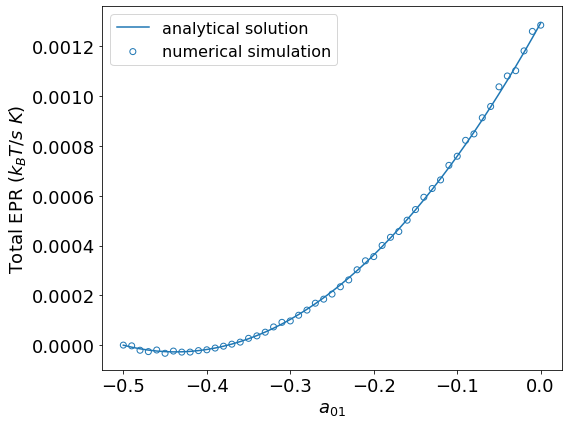

In [28]:
final_x0 = (-1)*np.array(qx1_slope_temp_list[2])
final_x1 = (-1)*np.array(qx2_slope_temp_list[2])

epr = (final_x0/np.array(pars['T0'])) + (final_x1/np.array(pars['T1'])) 

final_x0_analytical = np.array(q0_temp_list[2])
final_x1_analytical = np.array(q1_temp_list[2])

epr_analytical = (final_x0_analytical/np.array(pars['T0'])) + (final_x1_analytical/np.array(pars['T1'])) 

fig = plt.figure(figsize=(8,6))
plt.plot((-1)*a01_list, epr_analytical, color='tab:blue', label='analytical solution')
plt.scatter((-1)*a01_list, epr, facecolors='none', edgecolors='tab:blue', label='numerical simulation')

plt.xlabel('$a_{01}$', fontsize=18)
plt.ylabel('Total EPR ($k_B T/s$ $K$)', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=16)
# plt.ylim(-0.15,0.01)
plt.tight_layout()
plt.savefig('reciprocity_total_epr_eprnum_fin_v1.png', dpi=300)

plt.show()

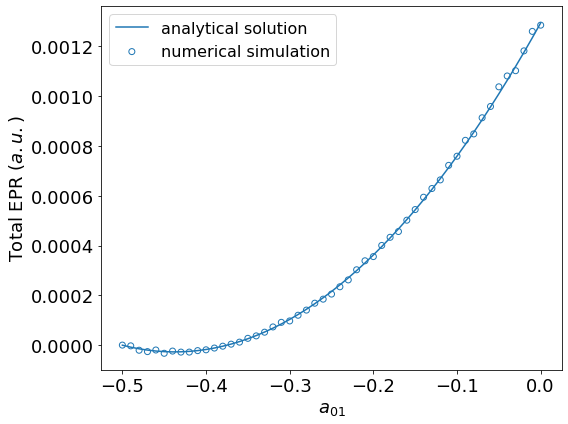

In [29]:
final_x0 = (-1)*np.array(qx1_slope_temp_list[2])
final_x1 = (-1)*np.array(qx2_slope_temp_list[2])

epr = (final_x0/np.array(pars['T0'])) + (final_x1/np.array(pars['T1'])) 

final_x0_analytical = np.array(q0_temp_list[2])
final_x1_analytical = np.array(q1_temp_list[2])

epr_analytical = (final_x0_analytical/np.array(pars['T0'])) + (final_x1_analytical/np.array(pars['T1'])) 

fig = plt.figure(figsize=(8,6))
plt.plot((-1)*a01_list, epr_analytical, color='tab:blue', label='analytical solution')
plt.scatter((-1)*a01_list, epr, facecolors='none', edgecolors='tab:blue', label='numerical simulation')

plt.xlabel('$a_{01}$', fontsize=18)
plt.ylabel('Total EPR ($a.u.$)', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=16)
# plt.ylim(-0.15,0.01)
plt.tight_layout()
plt.savefig('reciprocity_total_epr_eprnum_fin_v2.png', dpi=300)

plt.show()